# Gaussian Mixture Models
## This notebook outlines the main concepts behing the Gaussian Mixture Models in Machine Learning

Gaussian mixture models (GMMs) can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering

#### Import the necessary libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Why GMM ?

**Weaknesses of k-Means**

### Generate some data

In [6]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

### Plot the data with K Means Labels

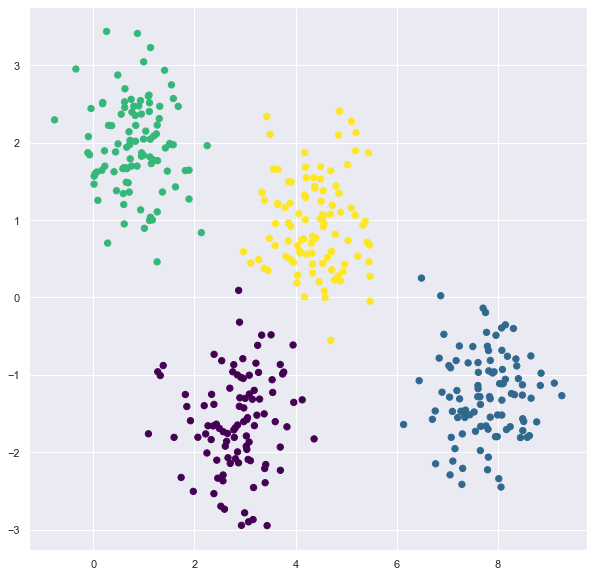

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

*k*-means model is that it places a **circle** (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster

This radius acts as a **hard cutoff for cluster assignment** within the training set: any point outside this circle is not considered a member of the cluster.


In [8]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

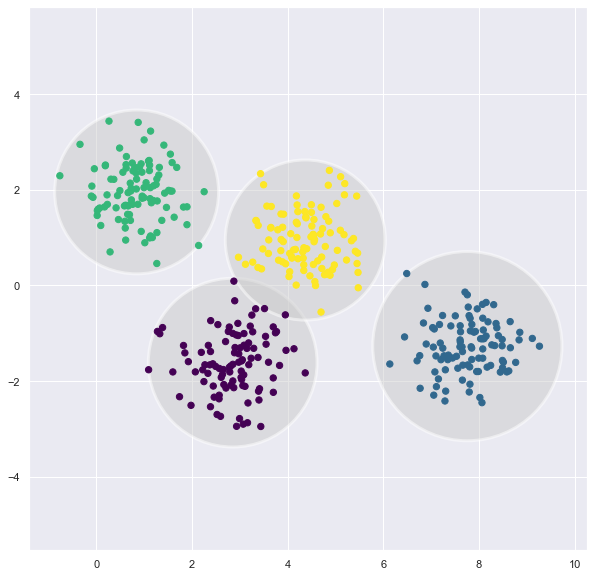

In [9]:
kmeans = KMeans(n_clusters=4, random_state=0)
plt.figure(figsize=(10,10))
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models *must be **circular**: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled

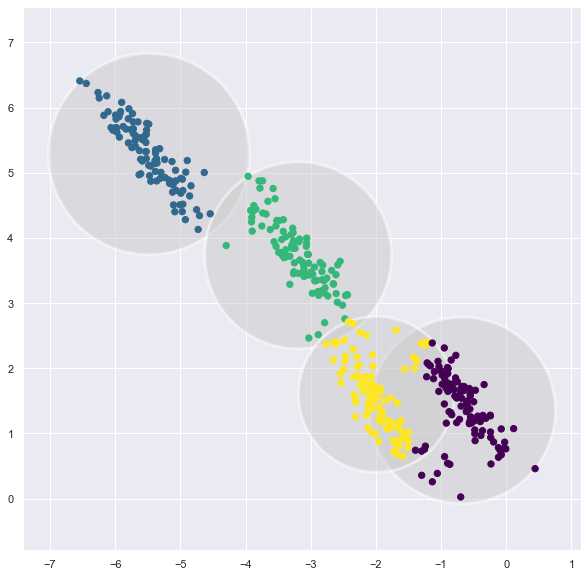

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plt.figure(figsize=(10,10))
plot_kmeans(kmeans, X_stretched)

Transformed clusters are non-circular, and thus circular clusters would be a poor fit.

Nevertheless, *k*-means is **not flexible** enough to account for this, and tries to force-fit the data into four circular clusters.

This results in a mixing of cluster assignments.


Disadvantages
- lack of probabilistic cluster assignment—mean 
- lack of flexibility in cluster shape

Solution
- Generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
- Allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.

Answer: **Gaussian Mixture Models**

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means.


GMM assumes a mixture of gaussian distributions to have generated the data. It uses with **soft-assignment** of data points to clusters(i.e. probabilistic and therefore better) contrasting with the K-means approach of hard-assignments of data points to clusters with the assumption of a circular distribution of data around centroids.

#### Usage
- Import the GMM Estimator
- Build a GMM model with number of components
- Train the model on the data
- Predict on data
- Plot the predicted labels

In [21]:
from sklearn.mixture import GaussianMixture as GMM

In [22]:
gmm = GMM(n_components=4).fit(X)

In [23]:
labels = gmm.predict(X)

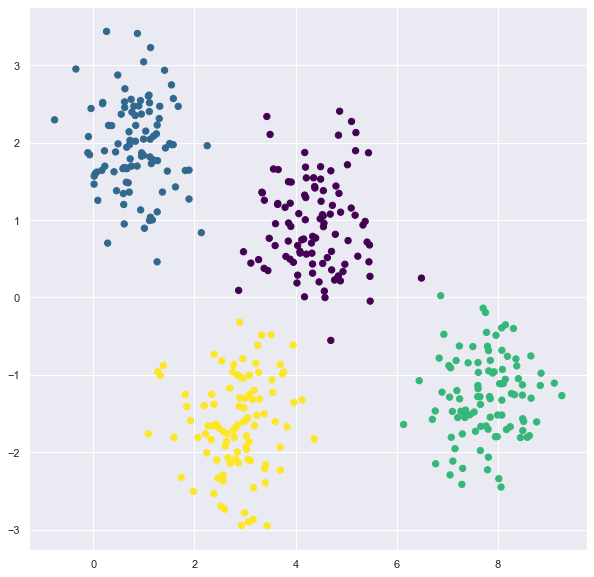

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

GMM contains a **probabilistic model** under the hood, it is also possible to find **probabilistic cluster assignments** 

**predict_proba()**

This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster

In [26]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.    0.469 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

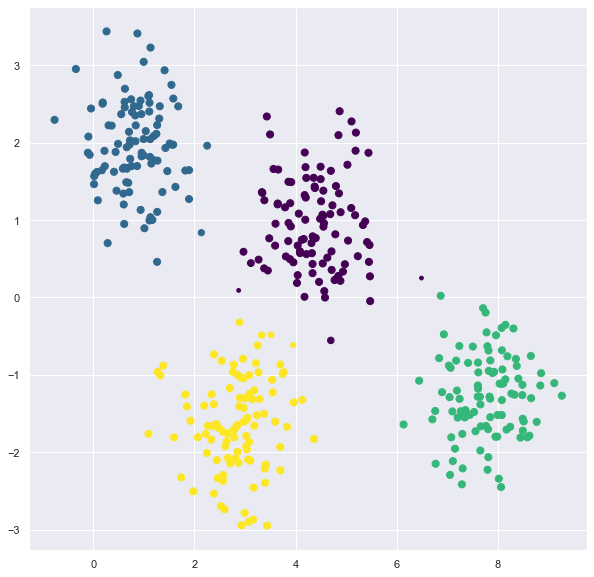

In [29]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an **expectation–maximization** approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

##### Visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output

In [30]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

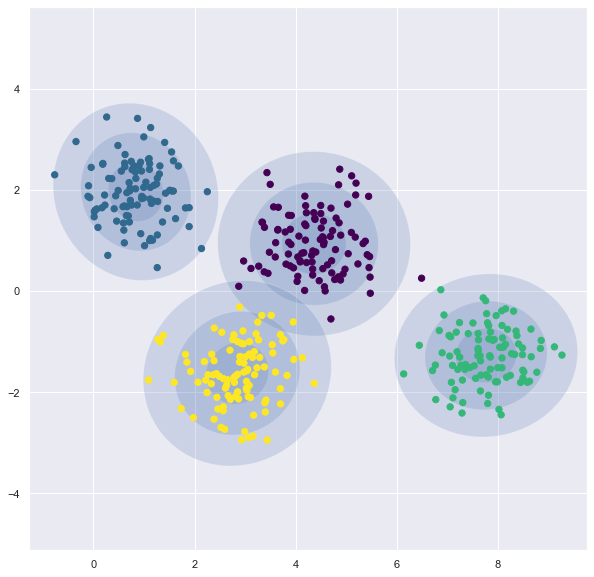

In [31]:
gmm = GMM(n_components=4, random_state=42)
plt.figure(figsize=(10,10))
plot_gmm(gmm, X)

Like above, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters

##### Let's stretch it out

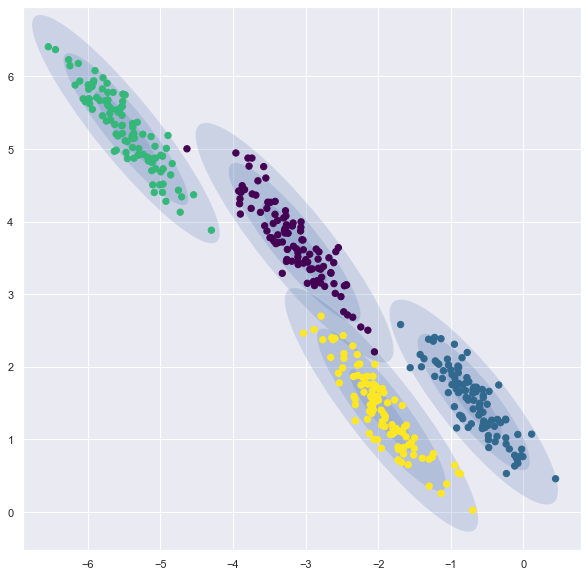

In [32]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plt.figure(figsize=(10,10))
plot_gmm(gmm, X_stretched)

Nice.... It addressed the always circular shape of the cluster in K-means

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

[(Covariance Type)](figures/05.12-covariance-type.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Covariance-Type)

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for **density estimation**.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.


#### Make moons

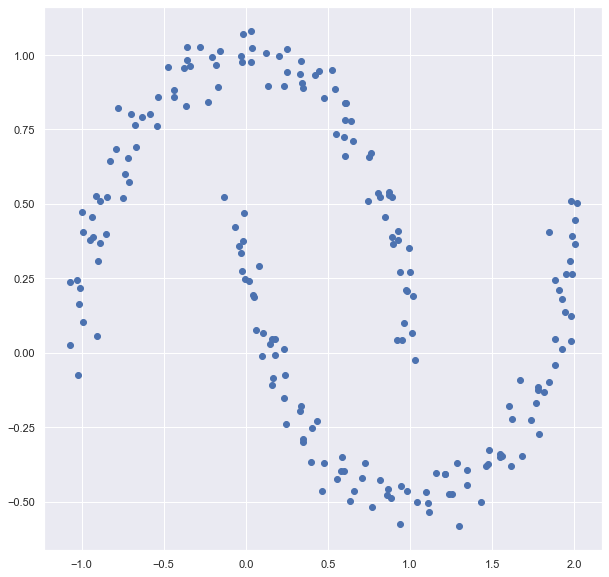

In [33]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.figure(figsize=(10,10))
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful

#### Try to fit a GMM model on the above data

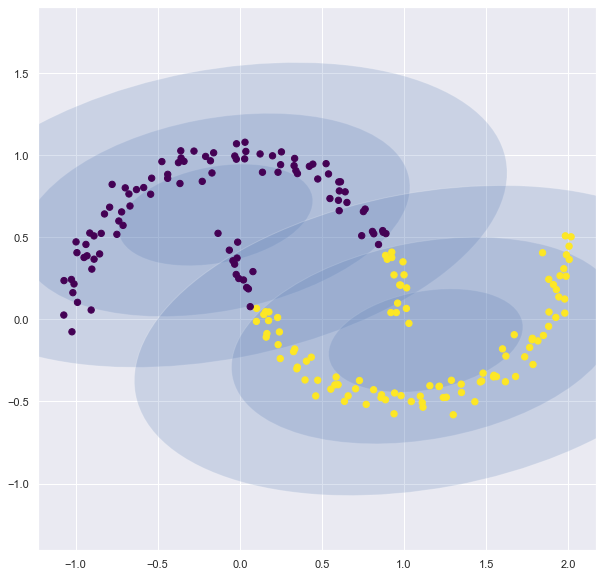

In [34]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plt.figure(figsize=(10,10))
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

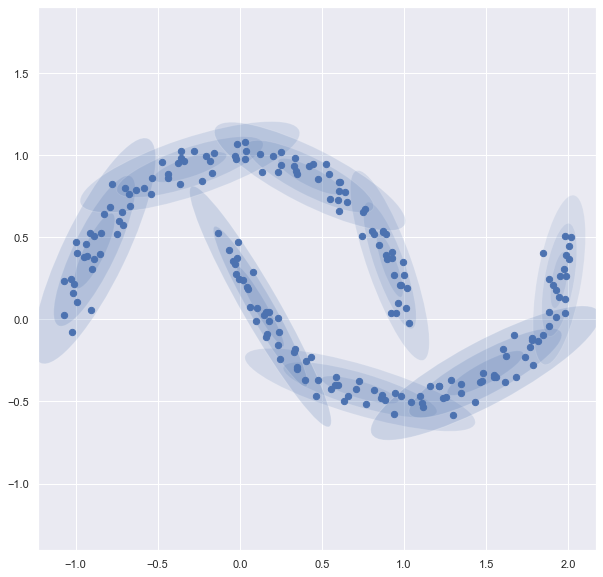

In [48]:
gmm16 = GMM(n_components=8, covariance_type='full', random_state=0)
plt.figure(figsize=(10,10))
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.

Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).


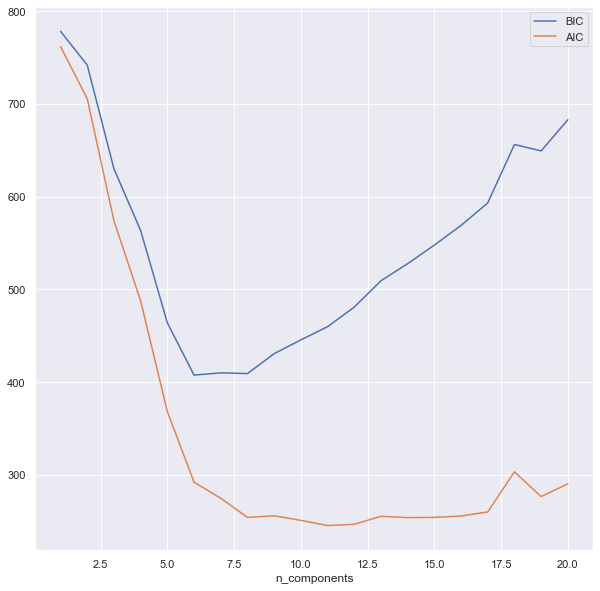

In [47]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]


plt.figure(figsize=(10,10))
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

##### Takeaway
Choice of number of components measures how well GMM works as a **density estimator**, not how well it works as a clustering algorithm.
- Use GMM first as a density estimator
- Use it as a clustering algorithm for simple datasets

### References and Further Reading
- Gaussian Mixture Models

https://towardsdatascience.com/gaussian-mixture-models-gmm-6e95cbc38e6e

- Clustering with GMMs

https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/

- Mathematical Intuition to GMMs

https://towardsdatascience.com/gaussian-mixture-models-d13a5e915c8e